# Projet final - Analyse de survie

**Master 2 MIASHS 2025/2026**

**Groupe:** Luan DECHERY et Enrique NASSEH FREITAS

Liens pour la documentation du dataset:
*   https://vincentarelbundock.github.io/Rdatasets/doc/carData/Rossi.html
*   https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html

**SOURCE:** Rossi, P.H., R.A. Berk, and K.J. Lenihan (1980). Money, Work, and Crime: Some Experimental Results. New York: Academic Press.

---

 **Objectif du projet:** Le dataset Rossi est un document qui regroupe 432 personnes condamnées à vol pendant les années 70 à Maryland. Ces individus sont suivis pendant 1 an (52 semaines) après leur libération jusqu’à une éventuelle récidive. Au cours de cette année, plusieurs caractéristiques individuelles sont observées (âge, antécédents, expérience de travail, …). Les individus sont repartis en 2 groupes équitables selon s’ils ont reçu ou non une aide financière du gouvernement pendant l’année d’étude.

L’objectif du projet est d’identifier les caractéristiques qui influencent sur une éventuelle récidive de ces personnes. On utilisera des méthodes comme le Kaplan Meier et la méthode de Cox afin de quantifier l’impact de ces caractéristiques sur le risque de récidive. Pour finir, une discussion sera ouverte pour échanger les limites du dataset et des statistiques produites.


## Dictionnaire de donnnées

| **Variable** | **Type** | **Commentaire** |
|--------------|----------|-----------------|
| `week` | integer | Temps jusqu'à la récidive ou la fin du suivi (en semaines, de 1 à 52) |
| `arrest` | boolean | Statut de l'événement : **1** pour récidive, **0** pour censure |
| `fin` | boolean | Aide financière : **1** pour oui, **0** pour non |
| `age` | integer | Âge au moment de la libération (en années) |
| `race` | boolean | Race : **1** pour Noir, **0** pour autre |
| `wexp` | boolean | Expérience professionnelle : **1** pour oui, **0** pour non |
| `mar` | boolean | Statut marital : **1** pour marié, **0** pour non marié |
| `paro` | boolean | Libération conditionnelle : **1** pour oui, **0** pour non |
| `prio` | integer | Nombre d'antécédents criminels avant l'incarcération |

# Présentation du jeu de données

In [ ]:
# Packages nécessaires pour la réalisation du projet

#!pip install lifelines
#!pip install Surv
#!pip install scikit-survival
import numpy as np
import lifelines
import matplotlib.pyplot as plt
import surv
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sksurv.metrics import brier_score
from sksurv.util import Surv
import pandas as pd
from scipy.stats import ks_2samp
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
import seaborn as sns
import types
import sys
from numbers import Real, Integral

In [ ]:
# Chargement du dataset

data = lifelines.datasets.load_rossi()
data.head()


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [ ]:
# Analyse descriptive du jeu de données

data.shape
data.describe()

,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000


* **26% des personnes sont revenus en prison dans la période de 52 semaines après leur libération**
* Moyenne d'age de 24,6
* 87% des individus sont considérés comme 'noir'
* 57% des individus ont déjà eu une expérience de travail
* 12% des individus sont mariés
* L'échantillon est divisé en 2 groupes équitables selon si ils ont reçu ou non une aide financière du gouvernement


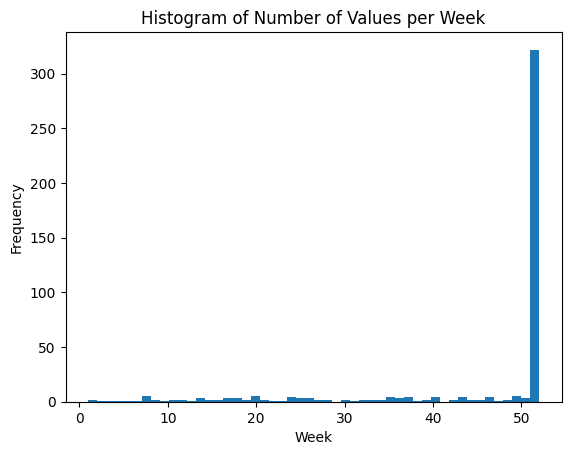

In [ ]:
plt.hist(data['week'], bins=50)
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Values per Week')
plt.show()

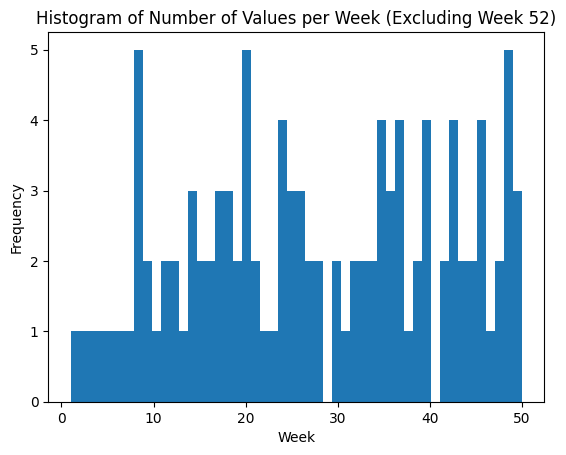

In [ ]:
data_filtered = data[data['week'] != 52]
plt.hist(data_filtered['week'], bins=50)
plt.xlabel('Week')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Values per Week (Excluding Week 52)')
plt.show()

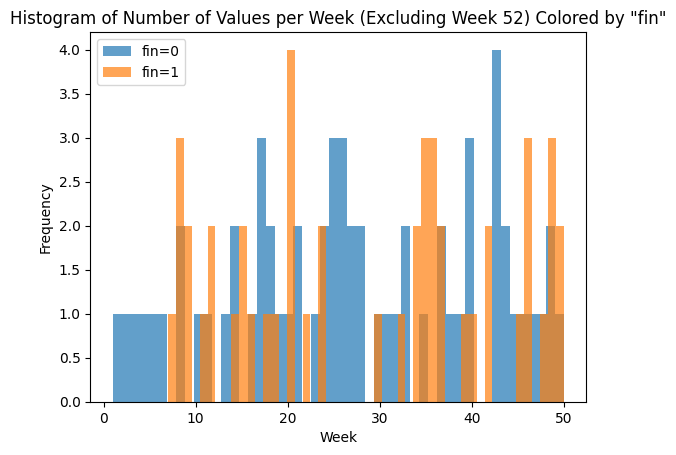

In [ ]:
import matplotlib.pyplot as plt

# Exclude data where week is 52
data_filtered = data[data['week'] != 52]

# Get unique values from the 'fin' column
fin_values = data_filtered['fin'].unique()

# Plot histograms for each 'fin' value
for fin_value in fin_values:
    subset = data_filtered[data_filtered['fin'] == fin_value]
    plt.hist(subset['week'], bins=50, label=f'fin={fin_value}', alpha=0.7)

plt.xlabel('Week')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Values per Week (Excluding Week 52) Colored by "fin"')
plt.legend()
plt.show()

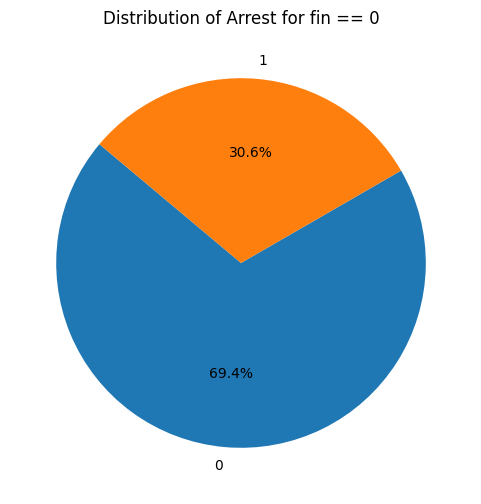

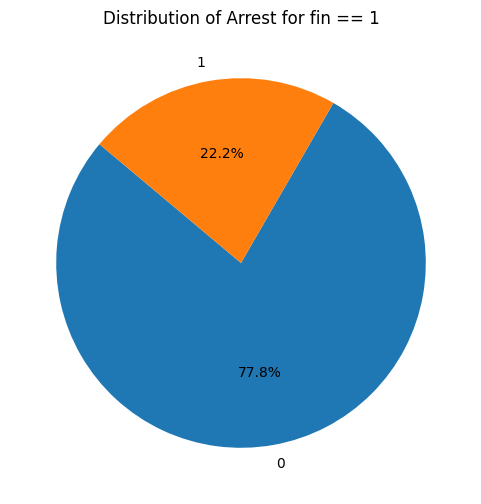

In [ ]:
import matplotlib.pyplot as plt

# Filter data for fin == 0
data_fin_0 = data[data['fin'] == 0]
arrest_counts_0 = data_fin_0['arrest'].value_counts()

# Create pie chart for fin == 0
plt.figure(figsize=(6, 6))
plt.pie(arrest_counts_0, labels=arrest_counts_0.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Arrest for fin == 0')
plt.show()

# Filter data for fin == 1
data_fin_1 = data[data['fin'] == 1]
arrest_counts_1 = data_fin_1['arrest'].value_counts()

# Create pie chart for fin == 1
plt.figure(figsize=(6, 6))
plt.pie(arrest_counts_1, labels=arrest_counts_1.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Arrest for fin == 1')
plt.show()

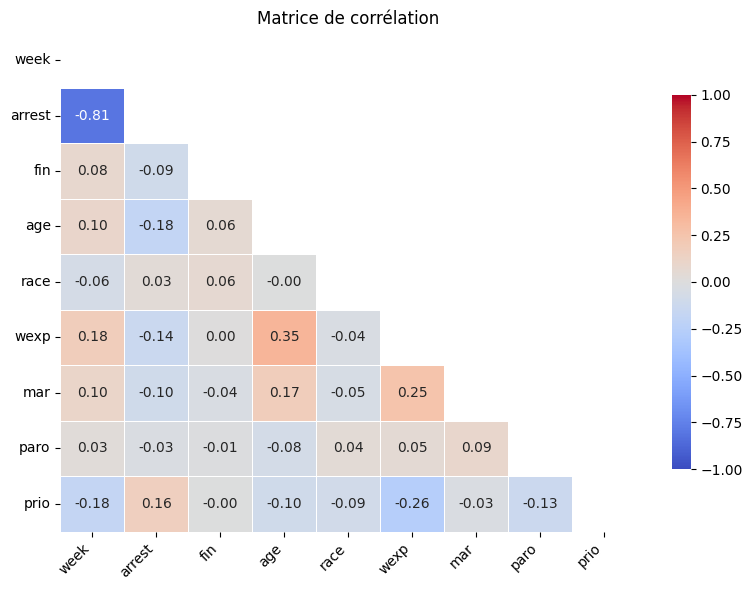

In [ ]:
# Matrice de corrélation (heatmap)
corr = data.corr()

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": .75})
plt.title("Matrice de corrélation")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyse de survie descriptive: Kaplan-Meier

L'estimateur de Kaplan-Meier est une méthode non-parametrique qui a pour objectif d'estimer la durée de survie d'un jeu de données contenant une distribuition temporelle

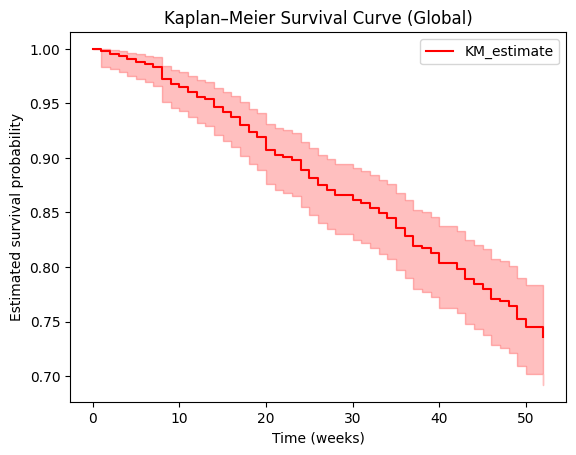

In [ ]:
# On commence par appliquer la méthode de Kaplan-Meier sur l'ensemble du jeu de données pour avoir la distribution complète sur toute les variables

kmf = lifelines.KaplanMeierFitter()
kmf.fit(data["week"], event_observed=data["arrest"])

kmf.plot_survival_function(ci_show=True, color="red")
plt.title("Kaplan–Meier Survival Curve (Global)")
plt.xlabel("Time (weeks)")
plt.ylabel("Estimated survival probability")
plt.show()

In [ ]:
median_survival = kmf.median_survival_time_
print(f"Temps de survie médian: {median_survival}")
print(f"Probabilité de survie minimale: { kmf.survival_function_.min().iloc[0]:.3f}")
print(f"Probabilité de survie maximale: {kmf.survival_function_.max().iloc[0]:.3f}")

Temps de survie médian: inf
Probabilité de survie minimale: 0.736
Probabilité de survie maximale: 1.000


En calculant le temps de survie médian, on voit qu'il est infini, ce qui signifie que plus de 50% des individus n'ont pas connu l'événement (arrestation) pendant la période d'étude de 52 semaines. Donc, un intervalle de confiance à 95% pour le temps de survie médian ne peut pas être calculé de manière significative.

Afin de contourner ce problème, on calculera la médiane de survie restreinte (Restricted Mean Survival Time - RMST). Cet indicateur nous permet d'évaluer l'espérance de survie moyenne sur une période fixe [Week 0 ; Week 52].


In [ ]:
rmst = lifelines.utils.restricted_mean_survival_time(kmf, t=max(data['week']))
print(f"La survie moyenne restreinte a la période [Week 0 ; Week 52] est de: {rmst:.2f} semaines.")

La survie moyenne restreinte a la période [Week 0 ; Week 52] est de: 45.85 semaines.


Ce résultat nous montre qu'en moyenne les individus ont une survie de 45.86 semaines pendant la période le l'étude. On utilisera cette valeur pour la suite des calculs.

On appliquera la méthode de Kapaln-Meier selon les covariables qu'on juge etre pertinantes pour la création de sous-groupes:
* fin: variable qui indique si l'individu a reçu une aide financière du gouvernement
* race: variable qui indique si l'individu est considére noir ou non
* wexp: varaible qui indique si l'individu a déjà eu une expérience de professionnelle
* paro: variable qui indique si l'individu a été liberés sur parole



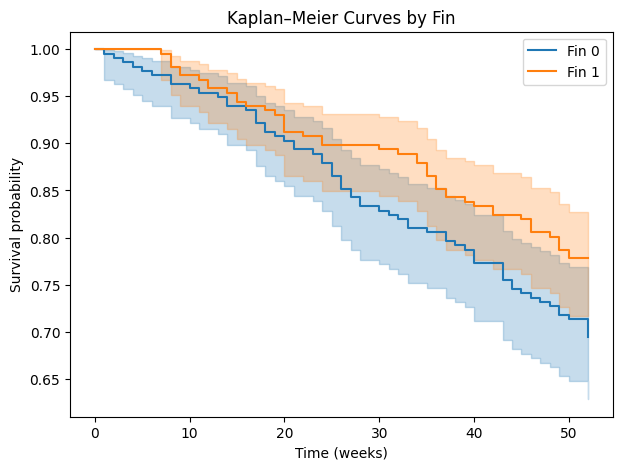

In [ ]:
plt.figure(figsize=(7,5))
for fin, group in data.groupby("fin"):
    kmf.fit(group["week"], event_observed=group["arrest"], label=f"Fin {fin}")
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Fin")
plt.xlabel("Time (weeks)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

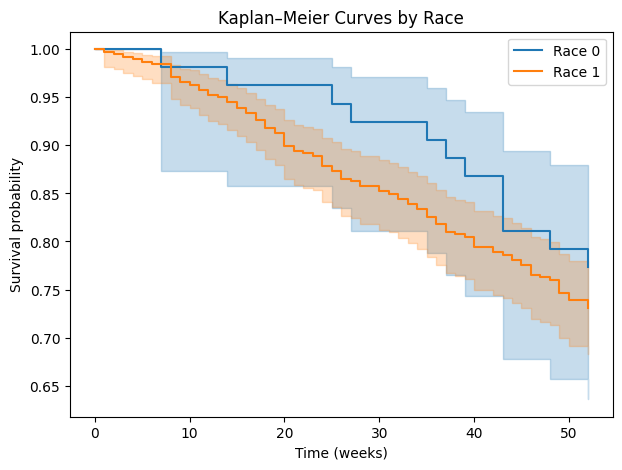

In [ ]:
plt.figure(figsize=(7,5))
for race, group in data.groupby("race"):
    kmf.fit(group["week"], event_observed=group["arrest"], label=f"Race {race}")
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Race")
plt.xlabel("Time (weeks)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

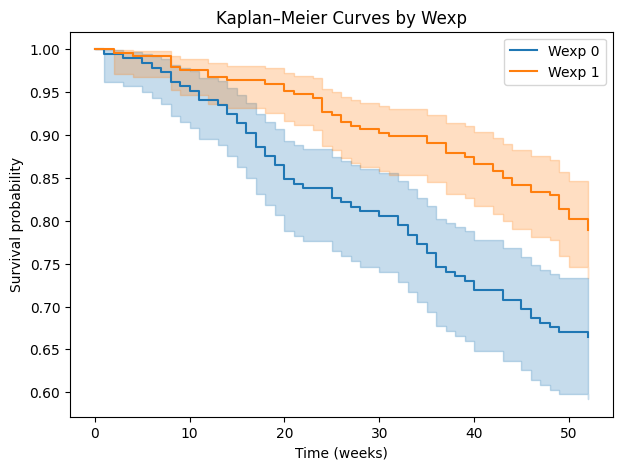

In [ ]:
plt.figure(figsize=(7,5))
for wexp, group in data.groupby("wexp"):
    kmf.fit(group["week"], event_observed=group["arrest"], label=f"Wexp {wexp}")
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Wexp")
plt.xlabel("Time (weeks)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

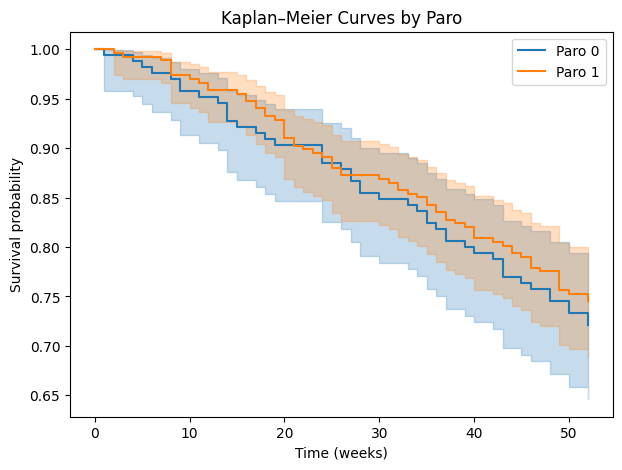

In [ ]:
plt.figure(figsize=(7,5))
for paro, group in data.groupby("paro"):
    kmf.fit(group["week"], event_observed=group["arrest"], label=f"Paro {paro}")
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Paro")
plt.xlabel("Time (weeks)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

De manière graphique, on peut supposer qu'il existe une différence significative entre les groupes selon la variable Wexp. Pour la variable Fin, on voit que la différence devient plus importante a partir du deuxième semestre de la période d'étude.

Pourtant, cette différence n'est pas visible a travers une analyse graphique pour les variables Race et Paro.

Afin d'évaluer cet écart de manière analytique, on appliquera un test du log-rank. Ce test a pour objectif de comparer la survie entre deux groupes pour identifier s'il existe une différence significative entre eux grace au calcul de la p-value. Pour cela, on doit mettre en place deux hypothèses:

*   **Hypothèse nulle (H₀):** Il n'y a aucune différence entre les fonctions de survie des deux groupes
*   **Hypothèse alternative (H₁):** Il existe au moins une différence entre les fonctions de survie


In [ ]:
alpha = 0.05

T_0_fin = data.loc[data['fin'] == 0, 'week']
E_0_fin = data.loc[data['fin'] == 0, 'arrest']
T_1_fin = data.loc[data['fin'] == 1, 'week']
E_1_fin = data.loc[data['fin'] == 1, 'arrest']
results_fin = logrank_test(T_0_fin, T_1_fin, event_observed_A=E_0_fin, event_observed_B=E_1_fin)

T_0_race = data.loc[data['race'] == 0, 'week']
E_0_race = data.loc[data['race'] == 0, 'arrest']
T_1_race = data.loc[data['race'] == 1, 'week']
E_1_race = data.loc[data['race'] == 1, 'arrest']
results_race = logrank_test(T_0_race, T_1_race, event_observed_A=E_0_race, event_observed_B=E_1_race)

T_0_wexp = data.loc[data['wexp'] == 0, 'week']
E_0_wexp = data.loc[data['wexp'] == 0, 'arrest']
T_1_wexp = data.loc[data['wexp'] == 1, 'week']
E_1_wexp = data.loc[data['wexp'] == 1, 'arrest']
results_wexp = logrank_test(T_0_wexp, T_1_wexp, event_observed_A=E_0_wexp, event_observed_B=E_1_wexp)

T_0_paro = data.loc[data['paro'] == 0, 'week']
E_0_paro = data.loc[data['paro'] == 0, 'arrest']
T_1_paro = data.loc[data['paro'] == 1, 'week']
E_1_paro = data.loc[data['paro'] == 1, 'arrest']
results_paro = logrank_test(T_0_paro, T_1_paro, event_observed_A=E_0_paro, event_observed_B=E_1_paro)

print("┌───────────┬─────────────┬──────────┬─────────────────────┐")
print("│ Variable  │ Statistique │ p-value  │ Diff. Significative │")
print("├───────────┼─────────────┼──────────┼─────────────────────┤")

variables = [
    ('fin', results_fin.test_statistic, results_fin.p_value),
    ('race', results_race.test_statistic, results_race.p_value),
    ('wexp', results_wexp.test_statistic, results_wexp.p_value),
    ('paro', results_paro.test_statistic, results_paro.p_value)
]

for var, stat, pval in variables:
    sign = "✓ OUI" if pval < alpha else "✗ NON"
    print(f"│ {var:<9} │ {stat:>11.3f} │ {pval:>8.4f} │ {sign:<18} │")

print("└───────────┴─────────────┴──────────┴─────────────────────┘")

┌───────────┬─────────────┬──────────┬─────────────────────┐
│ Variable  │ Statistique │ p-value  │ Diff. Significative │
├───────────┼─────────────┼──────────┼─────────────────────┤
│ fin       │       3.838 │   0.0501 │ ✗ NON              │
│ race      │       0.576 │   0.4478 │ ✗ NON              │
│ wexp      │       9.910 │   0.0016 │ ✓ OUI              │
│ paro      │       0.326 │   0.5681 │ ✗ NON              │
└───────────┴─────────────┴──────────┴─────────────────────┘


L'analyse montre que la variable (wexp) est le seul facteur ayant une influence statistiquement significative sur la récidive (p = 0,0016). Cela signifie que les individus ayant travaillé avant leur incarcération présentent un risque de récidive considérablement moins important de ceux sans expérience de travail. Les autres variables comme race, paro et fin ne montrent pas d'impact significatif sur la récidive dans cette analyse.

**À noter concernant l'aide financière (variable fin):** Cette variable est très proche du seuil  (p=0,0501), en étudiera cet effet limite plus en detail dans la prochaine partie.

# Modélisation paramétrique et semi-paramétrique

In [ ]:
# Remove rows containing NaN values
n_before = data.shape[0]
df = data.dropna()
print(f"Removed {n_before - df.shape[0]} ({100*(n_before - df.shape[0])/n_before:.2f}%) observations containing NaN values.")

Removed 0 (0.00%) observations containing NaN values.


In [ ]:
# Split the dataset
train, test = train_test_split(data, test_size=0.3, random_state=42)

# Fit Cox model
cph = CoxPHFitter()
cph.fit(train, duration_col="week", event_col="arrest")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 226 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 302
number of events observed = 76
   partial log-likelihood = -410.52
         time fit was run = 2025-11-16 21:25:26 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.61      0.54      0.24           -1.08           -0.14                0.34                0.87
age       -0.05      0.95      0.03           -0.10            0.00                0.90                1.00
race       0.27      1.32      0.36           -0.43            0.98                0.65                2.67
wexp       0.08      1.08      0.25           -0.42            0.58                0.66                1.78
mar       -0.68      0.51      0.48           -1.62            0.27                0.20                1.30
paro      -0.13      0.88      0.24           -0.59            0.34                0.55                1.40
prio       0.11      1.12      0.03            0.04            0.18                1.04                1.20

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -2.54   0.01      6.50
age          0.00 -1.91   0.06      4.17
race         0.00  0.76   0.45      1.16
wexp         0.00  0.31   0.76      0.40
mar          0.00 -1.41   0.16      2.65
paro         0.00 -0.53   0.59      0.75
prio         0.00  3.20 <0.005      9.52
---
Concordance = 0.66
Partial AIC = 835.05
log-likelihood ratio test = 26.26 on 7 df
-log2(p) of ll-ratio test = 11.11

Nous allons utiliser la métrique de la vraisemblance pour comparer ce modèle à d'autres, ici nous avons une log vraisemblance partielle de -410.52 (plus haut mieux c'est). Aussi comme le Partial AIC, qui va nous servir pour comparer des modèles entre eux (plus petit mieux c'est).

Le log likelihood ratio test est un test global, il évalue si le modèle complet explique mieux les données que le modèle nul (sans covariables). Un χ² de 26.26 avec 7 ddl → p < 0.005 → notre modèle global est donc significatif.

Concordance = 0.66
Indique la capacité du modèle à bien ordonner les temps de survie. 0.5 = hasard, 1 = parfait. Notre modèle est donc modérément bon.

In [ ]:
# Define significance level
alpha_value = 0.05

# Extract summary DataFrame from the fitted model
summary_df = cph.summary

print(f"Significant variables at alpha = {alpha_value}:\n{'-'*60}")
for var, row in summary_df.iterrows():
    p_val = row["p"]
    coef = row["coef"]
    hr = np.exp(coef)  # hazard ratio
    if p_val < alpha_value:
        effect = "increases" if coef > 0 else "decreases"
        print(f"- {var}:")
        print(f"   p = {p_val:.2e}")
        print(f"   Coefficient (β) = {coef:.3f}")
        print(f"   Hazard Ratio (exp(β)) = {hr:.3f}")
        print(f"   → This variable {effect} the risk of prison.\n")

Significant variables at alpha = 0.05:
------------------------------------------------------------
- fin:
   p = 1.11e-02
   Coefficient (β) = -0.612
   Hazard Ratio (exp(β)) = 0.542
   → This variable decreases the risk of prison.

- prio:
   p = 1.36e-03
   Coefficient (β) = 0.111
   Hazard Ratio (exp(β)) = 1.118
   → This variable increases the risk of prison.



Ici, nous observons les covariables les plus significatives pour la survie. La première est le financement. Notre étude porte sur une cohorte composée de deux groupes : un groupe ayant bénéficié d'un financement après sa sortie de prison, et un autre groupe n'ayant reçu aucun financement. Les résultats montrent que le financement a un effet protecteur. En effet, il est associé à une réduction du risque de récidive et de retour en prison.

La deuxième covariable significative est "prio", qui indique le nombre d'incarcérations antérieures. Comme attendu, plus un individu a connu d'emprisonnements précédents, plus son risque de récidive est élevé.

Les deux variables présentent une significativité statistique, confirmant la robustesse de ces associations.


On va tester notre modèle sur le jeu de données test pour avoir notre c_index (0,5 = hasard ; 1 = parfait)

In [ ]:
c_index = concordance_index(
    test["week"],
    -cph.predict_partial_hazard(test),
    test["arrest"]
)
print(f"C-index on test set: {c_index:.3f}")

C-index on test set: 0.571


Cet index nous montre que notre modèle a une capacité discriminative faible

In [ ]:
# Step 1 — Retrieve predicted survival functions
# ------------------------------------------------
# The Cox model can estimate the survival function for each individual

surv_funcs = cph.predict_survival_function(test)

# Choose a set of time horizons to evaluate calibration
#time_points = np.quantile(test["week"], [0.25, 0.5, 0.75]) # Problème pcq on a pas de quantile
time_points = np.arange(5, 52)  # weeks 1 to 52

print(f"Evaluating calibration at times: {time_points}")

# Convert test set to structured array for sksurv
y_test_struct = Surv.from_dataframe("arrest", "week", test)

# Define evaluation times
#time_points = np.quantile(test["week"], [0.25, 0.5, 0.75])
#print("Evaluating Brier score at times:", time_points)

# Predict survival probabilities for all individuals
surv_df = cph.predict_survival_function(test)  # DataFrame (index: times, columns: samples)

# Interpolate survival probabilities at required time points
surv_preds = np.vstack([
    np.interp(time_points, surv_df.index.values, surv_df[col].values)
    for col in surv_df.columns
])

# Compute Brier scores
times_brier, brier_scores = brier_score(
    y_test_struct, y_test_struct, surv_preds, times=time_points
)

# Print results
for t, bs in zip(times_brier, brier_scores):
    print(f"Brier score at t={t:.1f}: {bs:.4f}")

Evaluating calibration at times: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
Brier score at t=5.0: 0.0077
Brier score at t=6.0: 0.0147
Brier score at t=7.0: 0.0222
Brier score at t=8.0: 0.0223
Brier score at t=9.0: 0.0298
Brier score at t=10.0: 0.0351
Brier score at t=11.0: 0.0350
Brier score at t=12.0: 0.0424
Brier score at t=13.0: 0.0423
Brier score at t=14.0: 0.0492
Brier score at t=15.0: 0.0492
Brier score at t=16.0: 0.0634
Brier score at t=17.0: 0.0687
Brier score at t=18.0: 0.0686
Brier score at t=19.0: 0.0810
Brier score at t=20.0: 0.0942
Brier score at t=21.0: 0.0941
Brier score at t=22.0: 0.0992
Brier score at t=23.0: 0.0992
Brier score at t=24.0: 0.1059
Brier score at t=25.0: 0.1059
Brier score at t=26.0: 0.1120
Brier score at t=27.0: 0.1122
Brier score at t=28.0: 0.1150
Brier score at t=29.0: 0.1150
Brier score at t=30.0: 0.1212
Brier score at t=31.0: 0.1248
Brier score at t=3

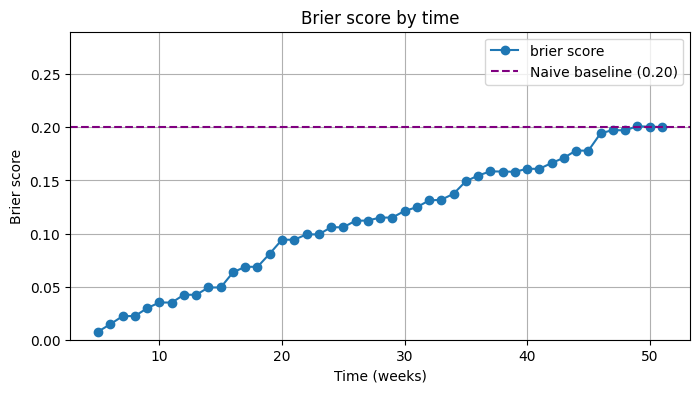

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(times_brier, brier_scores, marker="o", linestyle="-",label = "brier score", color="C0")
plt.axhline(y=0.20, color="purple", linestyle="--", label="Naive baseline (0.20)")
plt.xlabel("Time (weeks)")
plt.ylabel("Brier score")
plt.title("Brier score by time")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.29)
plt.show()

L'analyse de calibration montre que le modèle prédit bien le risque à court terme, avec une précision qui diminue progressivement sur le long terme. Cette tendance peut etre normale dans les études sur la récidive, car de nombreux facteurs imprévisibles peuvent influencer le comportement des personnes avec le temps.

Calibration evaluated at t* = 45.9 days


/tmp/ipython-input-3880907392.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_calib.groupby("bin").apply(
/tmp/ipython-input-3880907392.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration = df_calib.groupby("bin").apply(
/tmp/ipython-input-3880907392.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0.5, 1], [0.5, 1], "k--", label="Perfect calibrati

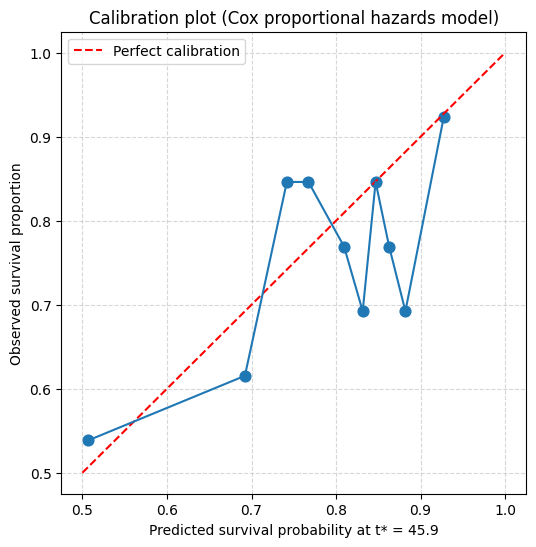

In [ ]:
# Step 3 — Calibration plot
# ------------------------------------------------
# === Calibration plot ===
# Horizon temporel à évaluer (ex. médiane de la cohorte)
# Horizon temporel (ex. médiane)
t_star = rmst
print(f"Calibration evaluated at t* = {t_star:.1f} days")

# === 1. Predicted survival curves ===
# The model outputs a survival function for each individual in the test set.
# The resulting DataFrame has time points as rows and individuals as columns.
surv_df = cph.predict_survival_function(test)

# Interpolate survival probability at the chosen horizon t_star for each individual
pred_surv_t = np.array([
    np.interp(t_star, surv_df.index.values, surv_df[col].values)
    for col in surv_df.columns
])

# === 2. Observed outcomes ===
# Build a DataFrame that combines predicted survival probabilities with observed outcomes
df_calib = pd.DataFrame({
    "predicted": pred_surv_t,
    "status": test["arrest"],
    "time": test["week"]
})

# === 3. Binning (deciles) ===
# Divide individuals into 10 equally sized groups based on predicted probabilities
n_bins = 10
df_calib["bin"] = pd.qcut(df_calib["predicted"], q=n_bins, duplicates="drop")

# For each bin: compute the average predicted survival and observed survival proportion
calibration = df_calib.groupby("bin").apply(
    lambda d: pd.Series({
        "mean_pred": d["predicted"].mean(),
        "obs_surv": np.mean(d["time"] > t_star)
    })
).reset_index(drop=True)

# === 4. Calibration plot ===
# Compare predicted vs observed survival probabilities at time t*
plt.figure(figsize=(6, 6))
plt.plot([0.5, 1], [0.5, 1], "k--", label="Perfect calibration", color="red")
plt.scatter(calibration["mean_pred"], calibration["obs_surv"], color="C0", s=60)
plt.plot(calibration["mean_pred"], calibration["obs_surv"], color="C0")
plt.xlabel(f"Predicted survival probability at t* = {t_star:.1f}")
plt.ylabel("Observed survival proportion")
plt.title("Calibration plot (Cox proportional hazards model)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
pred_surv_t

array([0.66560033, 0.94726683, 0.86235728, 0.84406108, 0.83102964,
       0.82235959, 0.75535326, 0.84136865, 0.86506742, 0.70802449,
       0.73054697, 0.81278899, 0.75571209, 0.86688034, 0.76843848,
       0.53842766, 0.8412106 , 0.86831917, 0.72703372, 0.79553004,
       0.66210431, 0.87471301, 0.91635443, 0.83010626, 0.85713932,
       0.71918281, 0.92787988, 0.92752986, 0.79225529, 0.94266298,
       0.88384864, 0.82850483, 0.93560171, 0.86371735, 0.91071018,
       0.90371793, 0.84540397, 0.38903535, 0.74177434, 0.74793766,
       0.86975688, 0.83853534, 0.76606487, 0.73897364, 0.8403798 ,
       0.72509662, 0.72000015, 0.82576017, 0.5308037 , 0.92829268,
       0.84171195, 0.77316822, 0.81940211, 0.77406574, 0.82238018,
       0.86496728, 0.87312539, 0.9200701 , 0.87384467, 0.84355865,
       0.86328232, 0.59737049, 0.6486109 , 0.91731566, 0.82020052,
       0.81866309, 0.86080734, 0.87221224, 0.77118793, 0.30863801,
       0.76340194, 0.86080734, 0.74793766, 0.72592557, 0.66971

Ce "calibration plot" montre la probabilité de survie prédite par le modèle à un instant t∗ donné (ici basé sur le RMST), comparée au taux de survie réellement observé. La ligne rouge en pointillé représente la calibration parfaite, où les probabilités prédites correspondraient exactement aux proportions observées.

La ligne bleue correspond aux prédictions de notre modèle pour 10 bins différents. On observe que pour certaines valeurs, notamment autour de 50%, le modèle prédit assez précisément. Cependant, pour les taux de survie plus élevés, les prédictions deviennent plus instables et s’écartent davantage de la ligne de calibration parfaite, indiquant que le modèle a plus de difficulté à estimer correctement les survies élevées. (Ce qui parait cohérent avec les résultats du Brier score au dessus)

In [ ]:
def calibration_error(calibration_df):
    """
    Compute the mean squared calibration error between predicted and observed survival.

    Parameters
    ----------
    calibration_df : pandas.DataFrame
        Must contain columns 'mean_pred' and 'obs_surv'.

    Returns
    -------
    float
        Mean squared error (MSE) between the calibration curve and the perfect line y = x.
    """
    mse = np.mean((calibration_df["mean_pred"] - calibration_df["obs_surv"]) ** 2)
    return np.sqrt(mse)

# Example usage
CE = calibration_error(calibration)
print(f"Calibration Error (distance to y=x): {CE:.4f}")

Calibration Error (distance to y=x): 0.0947


Avec une erreur de calibration de 0,0947, le modèle se situe dans une zone acceptable:

*  Il classe correctement les risques (discrimination correcte, C-index probable entre 0,65-0,70)
*  Mais ses probabilités absolues sont imprécises : il surestime ou sous-estime systématiquement le risque dans certains groupes de patients

En résumé : le modèle identifie bien les patients à haut risque, mais la probabilité exacte qu'il leur attribue manque de précision.

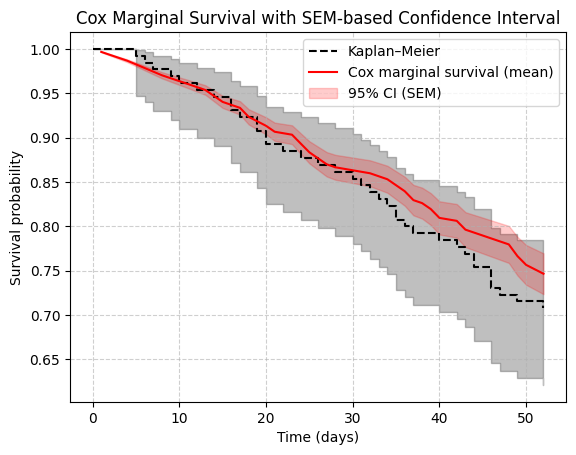

In [ ]:
# Compute mean survival and SEM-based confidence intervals
mean_surv = surv_df.mean(axis=1)
sem = surv_df.std(axis=1) / np.sqrt(surv_df.shape[1])  # SEM across individuals

z = 1.96  # for 95% CI
lower_ci = mean_surv - z * sem
upper_ci = mean_surv + z * sem

# Plot Kaplan–Meier
kmf.fit(test["week"], event_observed=test["arrest"], label="Kaplan–Meier")
ax = kmf.plot(ci_show=True, color="black", linestyle="--")

# Plot Cox mean survival and SEM-based CI
plt.plot(mean_surv.index, mean_surv.values, color="red", label="Cox marginal survival (mean)")
plt.fill_between(mean_surv.index, lower_ci.values, upper_ci.values,
                 color="red", alpha=0.2, label="95% CI (SEM)")

plt.title("Cox Marginal Survival with SEM-based Confidence Interval")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [ ]:
# === Significance threshold ===
alpha_value = 0.05

# === 1. Kolmogorov–Smirnov test ===
# We compare the two empirical survival distributions (Kaplan–Meier vs Cox)
ks_stat, ks_pvalue = ks_2samp(
    kmf.survival_function_.values.flatten(),
    mean_surv.values
)

print("Kolmogorov–Smirnov Test")
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
if ks_pvalue < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: the two survival distributions differ significantly.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference detected.")
print("-" * 70)

# === 2. Log-rank test ===
# For the log-rank test, we need to compare event times between two groups.
# Here we split individuals into "high" vs "low" predicted risk based on the median Cox risk score.
median_risk = cph.predict_partial_hazard(test).median()
group_high = test[cph.predict_partial_hazard(test) > median_risk]
group_low = test[cph.predict_partial_hazard(test) <= median_risk]

results_logrank = logrank_test(
    group_high["week"], group_low["week"],
    event_observed_A=group_high["arrest"],
    event_observed_B=group_low["arrest"]
)

print("Log-rank Test (High vs Low Cox risk)")
print(f"Test statistic: {results_logrank.test_statistic:.4f}, p-value: {results_logrank.p_value:.4f}")
if results_logrank.p_value < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: survival curves are significantly different.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference.")
print("-" * 70)

Kolmogorov–Smirnov Test
KS statistic: 0.1474, p-value: 0.7705
→ Fail to reject H0 at α=0.05: no significant difference detected.
----------------------------------------------------------------------
Log-rank Test (High vs Low Cox risk)
Test statistic: 0.2038, p-value: 0.6517
→ Fail to reject H0 at α=0.05: no significant difference.
----------------------------------------------------------------------


### Random forest

In [ ]:
X_train = train.drop(columns=["week", "arrest"])
print("X_train shape:", X_train.shape)

X_test = test.drop(columns=["week", "arrest"])
print("X_test shape:", X_test.shape)

X_train shape: (302, 7)
X_test shape: (130, 7)


In [ ]:
# Features
X_train = train.drop(columns=["week", "arrest"])
X_test = test.drop(columns=["week", "arrest"])

# Target
y_train = Surv.from_dataframe("arrest", "week", train)

# RSF
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=0)
rsf.fit(X_train.to_numpy(), y_train)

# Prediction sur test
pred = rsf.predict(X_test.to_numpy())

# C-index
from sksurv.metrics import concordance_index_censored
cindex = concordance_index_censored(test["arrest"].astype(bool), test["week"], pred)[0]
print("C-index RSF:", cindex)


C-index RSF: 0.6179909329515628


Le RSF montre une légère amélioration par rapport au modèle de Cox, mais la performance globale reste insuffisante pour une application clinique robuste. Cela suggère que les données disponibles ne contiennent pas suffisamment d'information prédictive forte, ou que des variables importantes manquent dans le modèle.

  feature  importance
6    prio    0.040802
1     age    0.036674
3    wexp    0.030410
4     mar    0.012765
2    race    0.004617
5    paro    0.003460
0     fin   -0.016738


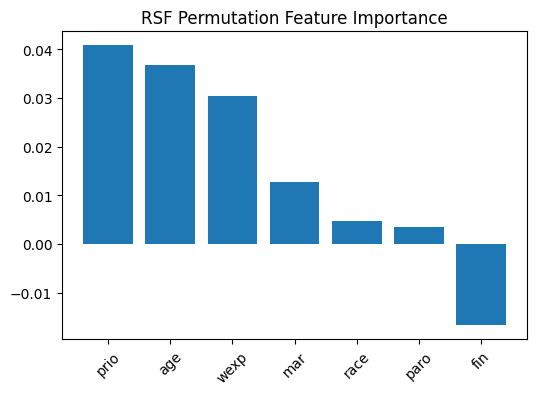

In [ ]:
# Fonction score pour permutation importance
def c_index_score(model, X, y):
    pred = model.predict(X)
    return concordance_index_censored(y["arrest"].astype(bool), y["week"], pred)[0]

y_test_struct = test[["arrest","week"]]

perm_imp = permutation_importance(
    rsf, X_test.to_numpy(), y_test_struct,
    scoring=c_index_score, n_repeats=10, random_state=42
)

# Affichage
import pandas as pd
feat_imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": perm_imp.importances_mean
}).sort_values("importance", ascending=False)

print(feat_imp_df)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(feat_imp_df["feature"], feat_imp_df["importance"])
plt.xticks(rotation=45)
plt.title("RSF Permutation Feature Importance")
plt.show()


Le modèle identifie correctement prio comme le facteur de risque principal, ce qui est cliniquement cohérent. Mais, la performance faible du modèle (C-index 0.618) et l'importance limitée des autres variables nous dit que des facteurs de risque importants ne sont pas capturés dans les données actuelles.

In [ ]:
y_train_struct = Surv.from_dataframe("arrest", "week", train)
y_test_struct = Surv.from_dataframe("arrest", "week", test)

# Choix de temps pour évaluer le score
time_points = [10, 20, 30, 40, 50]  # ou np.quantile(test["week"], [0.25, 0.5, 0.75])

# Probabilités de survie pour chaque individu et chaque temps
pred_surv = rsf.predict_survival_function(X_test.to_numpy())

import numpy as np
# Convertir en matrice (individus x temps)
pred_surv_matrix = np.array([fn(time_points) for fn in pred_surv])

times_brier, brier_scores = brier_score(
    y_train_struct, y_test_struct, pred_surv_matrix, times=time_points
)

for t, bs in zip(times_brier, brier_scores):
    print(f"Brier score at t={t}: {bs:.4f}")


Brier score at t=10: 0.0375
Brier score at t=20: 0.0928
Brier score at t=30: 0.1195
Brier score at t=40: 0.1615
Brier score at t=50: 0.1962


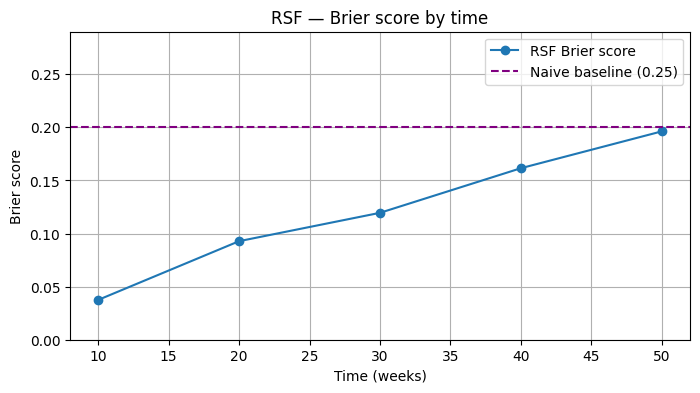

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Tes données RSF ---
times_rsf = np.array([10, 20, 30, 40, 50])
brier_rsf = np.array([0.0375, 0.0928, 0.1195, 0.1615, 0.1962])

# --- Graphique ---
plt.figure(figsize=(8, 4))
plt.plot(times_rsf, brier_rsf, marker="o", linestyle="-",
         label="RSF Brier score", color="C0")

plt.axhline(y=0.20, color="purple", linestyle="--", label="Naive baseline (0.25)")

plt.xlabel("Time (weeks)")
plt.ylabel("Brier score")
plt.title("RSF — Brier score by time")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.29)
plt.show()


Calibration evaluated at t* = 45.9 days


/tmp/ipython-input-1957289883.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df.groupby("bin").apply(
/tmp/ipython-input-1957289883.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration = df.groupby("bin").apply(
/tmp/ipython-input-1957289883.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

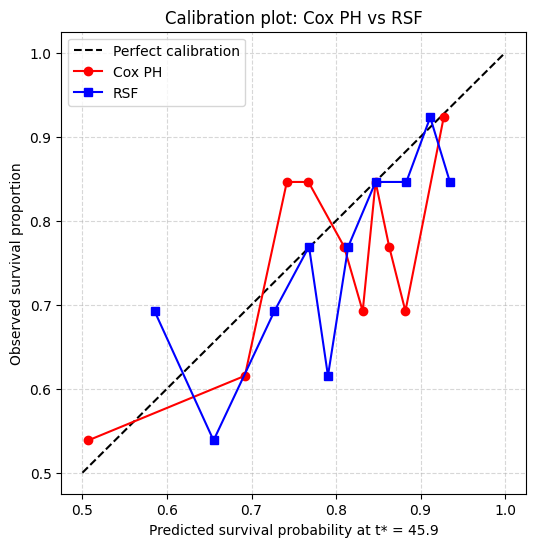

In [ ]:
# --- Horizon temporel ---
t_star = rmst  # ou np.median(test["week"])
print(f"Calibration evaluated at t* = {t_star:.1f} days")

# --- 1. Probabilités de survie à t_star ---
# Cox
surv_cox = cph.predict_survival_function(test)
pred_surv_cox = np.array([
    np.interp(t_star, surv_cox.index.values, surv_cox[col].values)
    for col in surv_cox.columns
])

# RSF
surv_rsf = rsf.predict_survival_function(X_test.to_numpy())
pred_surv_rsf = np.array([
    fn(t_star) for fn in surv_rsf
])

# --- 2. Construire DataFrames pour calibration ---
df_cox = pd.DataFrame({
    "predicted": pred_surv_cox,
    "status": test["arrest"],
    "time": test["week"]
})
df_rsf = pd.DataFrame({
    "predicted": pred_surv_rsf,
    "status": test["arrest"],
    "time": test["week"]
})

# --- 3. Binning (déciles) et calcul observed survival ---
def calc_calibration(df, n_bins=10):
    df["bin"] = pd.qcut(df["predicted"], q=n_bins, duplicates="drop")
    calibration = df.groupby("bin").apply(
        lambda d: pd.Series({
            "mean_pred": d["predicted"].mean(),
            "obs_surv": np.mean(d["time"] > t_star)
        })
    ).reset_index(drop=True)
    return calibration

calib_cox = calc_calibration(df_cox)
calib_rsf = calc_calibration(df_rsf)

# --- 4. Plot calibration curves ---
plt.figure(figsize=(6,6))
plt.plot([0.5,1], [0.5,1], "k--", color="black", label="Perfect calibration")
plt.plot(calib_cox["mean_pred"], calib_cox["obs_surv"], marker='o', color="red", label="Cox PH")
plt.plot(calib_rsf["mean_pred"], calib_rsf["obs_surv"], marker='s', color="blue", label="RSF")
plt.xlabel(f"Predicted survival probability at t* = {t_star:.1f}")
plt.ylabel("Observed survival proportion")
plt.title("Calibration plot: Cox PH vs RSF")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


In [ ]:
CE = calibration_error(calib_rsf)
print(f"Calibration Error (distance to y=x): {CE:.4f}")

Calibration Error (distance to y=x): 0.0826


Cette fois en ce qui concerne le plot de calibration pour les deux modèles on voit que le modèle RSF semble être plus instable au début et plus stable pour les proportions plus hautes comparés au modèle de Cox.

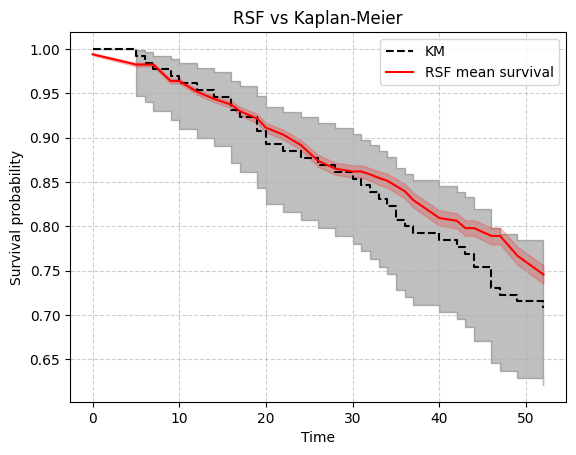

In [ ]:
# Courbe Kaplan-Meier réelle
kmf = lifelines.KaplanMeierFitter()
kmf.fit(test["week"], event_observed=test["arrest"], label="KM")
ax = kmf.plot(ci_show=True, color="black", linestyle="--")

# Courbe RSF moyenne
pred_surv_matrix = np.array([fn(kmf.survival_function_.index) for fn in pred_surv])
mean_surv = pred_surv_matrix.mean(axis=0)

plt.plot(kmf.survival_function_.index, mean_surv, color="red", label="RSF mean survival")
plt.fill_between(
    kmf.survival_function_.index,
    mean_surv - pred_surv_matrix.std(axis=0)/np.sqrt(pred_surv_matrix.shape[0]),
    mean_surv + pred_surv_matrix.std(axis=0)/np.sqrt(pred_surv_matrix.shape[0]),
    color="red", alpha=0.2
)
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("RSF vs Kaplan-Meier")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
import numpy as np
from lifelines.statistics import logrank_test
from scipy.stats import ks_2samp

# === Significance threshold ===
alpha_value = 0.05

# === 1. Kolmogorov–Smirnov test ===
# We compare the two empirical survival distributions (Kaplan–Meier vs RSF)
ks_stat, ks_pvalue = ks_2samp(
    kmf.survival_function_.values.flatten(),
    mean_surv
)

print("Kolmogorov–Smirnov Test")
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
if ks_pvalue < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: the two survival distributions differ significantly.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference detected.")
print("-" * 70)

# === 2. Log-rank test ===
# For the log-rank test, we need to compare event times between two groups.
# Here we split individuals into "high" vs "low" predicted risk based on the median RSF risk score.
median_risk = np.median(rsf.predict(X_test.to_numpy()))
group_high = test[rsf.predict(X_test.to_numpy()) > median_risk]
group_low = test[rsf.predict(X_test.to_numpy()) <= median_risk]

results_logrank = logrank_test(
    group_high["week"], group_low["week"],
    event_observed_A=group_high["arrest"],
    event_observed_B=group_low["arrest"]
)

print("Log-rank Test (High vs Low RSF risk)")
print(f"Test statistic: {results_logrank.test_statistic:.4f}, p-value: {results_logrank.p_value:.4f}")
if results_logrank.p_value < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: survival curves are significantly different.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference.")
print("-" * 70)

Kolmogorov–Smirnov Test
KS statistic: 0.1875, p-value: 0.6351
→ Fail to reject H0 at α=0.05: no significant difference detected.
----------------------------------------------------------------------
Log-rank Test (High vs Low RSF risk)
Test statistic: 2.8202, p-value: 0.0931
→ Fail to reject H0 at α=0.05: no significant difference.
----------------------------------------------------------------------


### Cox Regularized

In [ ]:
# Create a fake module to emulate 'sklearn.utils._param_validation'
# (used by skglm in newer versions of scikit-learn, >=1.3)
param_validation = types.ModuleType("sklearn.utils._param_validation")

# Define a minimal replacement for Interval used in _parameter_constraints
class Interval:
    def __init__(self, dtype, left, right, closed="neither"):
        self.dtype = dtype
        self.left = left
        self.right = right
        self.closed = closed

# Define a minimal replacement for StrOptions used in _parameter_constraints
class StrOptions:
    def __init__(self, options):
        self.options = set(options)

# Add the custom classes to the fake module
param_validation.Interval = Interval
param_validation.StrOptions = StrOptions

# Inject the fake module into sys.modules before skglm is imported
# This prevents skglm from raising an ImportError if sklearn < 1.3
sys.modules["sklearn.utils._param_validation"] = param_validation

In [ ]:
# === Imports ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
from lifelines.datasets import load_lung
from tqdm import tqdm

# Define features and target
X = data.drop(columns=["week", "arrest"])
y = data[["week", "arrest"]]  # Keep both as a DataFrame (not a tuple)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Combine X and y for lifelines
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Check shapes
print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Train: (302, 9), Test: (130, 9)


In [ ]:
# === Cox Elastic Net ===
alphas = np.logspace(-3, 1, 10)     # penalizer strengths
l1_ratios = np.arange(0.1, 1.01, 0.1)        # mix between L1 and L2 penalties

best_cindex_en = -np.inf
best_params_en = None
best_model_en = None

# Grid search over (alpha, l1_ratio)
for alpha in tqdm(alphas, desc="Scanning penalizer values"):
    for l1_ratio in l1_ratios:
        cph = CoxPHFitter(penalizer=alpha, l1_ratio=l1_ratio)
        cph.fit(train_df, duration_col="week", event_col="arrest")

        preds = -cph.predict_partial_hazard(test_df)
        cindex = concordance_index(
            test_df["week"],
            preds,
            test_df["arrest"]
        )

        if cindex > best_cindex_en:
            best_cindex_en = cindex
            best_params_en = (alpha, l1_ratio)
            best_model_en = cph

print("\n=== Elastic Net optimization results ===")
print(f"Best penalizer (alpha): {best_params_en[0]:.4f}")
print(f"Best L1 ratio: {best_params_en[1]}")
print(f"Best C-index (test): {best_cindex_en:.3f}")

Scanning penalizer values: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


=== Elastic Net optimization results ===
Best penalizer (alpha): 0.4642
Best L1 ratio: 0.9
Best C-index (test): 0.628


In [ ]:
cph = CoxPHFitter(penalizer=best_params_en[0], l1_ratio=best_params_en[1])
cph.fit(train_df, duration_col="week", event_col="arrest")

<lifelines.CoxPHFitter: fitted with 302 total observations, 226 right-censored observations>

In [ ]:
surv_funcs = cph.predict_survival_function(test)

# Choose a set of time horizons to evaluate calibration
#time_points = np.quantile(test["week"], [0.25, 0.5, 0.75]) # Problème pcq on a pas de quantile
time_points = np.arange(5, 52)  # weeks 1 to 52

print(f"Evaluating calibration at times: {time_points}")

# Convert test set to structured array for sksurv
y_test_struct = Surv.from_dataframe("arrest", "week", test)

# Define evaluation times
#time_points = np.quantile(test["week"], [0.25, 0.5, 0.75])
#print("Evaluating Brier score at times:", time_points)

# Predict survival probabilities for all individuals
surv_df = cph.predict_survival_function(test)  # DataFrame (index: times, columns: samples)

# Interpolate survival probabilities at required time points
surv_preds = np.vstack([
    np.interp(time_points, surv_df.index.values, surv_df[col].values)
    for col in surv_df.columns
])

# Compute Brier scores
times_brier, brier_scores = brier_score(
    y_test_struct, y_test_struct, surv_preds, times=time_points
)


Evaluating calibration at times: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]


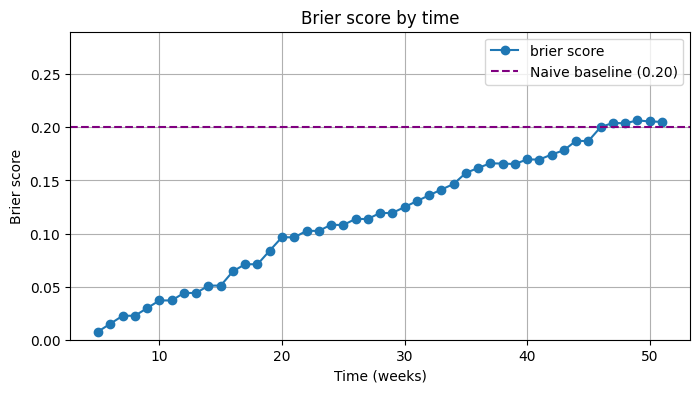

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(times_brier, brier_scores, marker="o", linestyle="-",label = "brier score", color="C0")
plt.axhline(y=0.20, color="purple", linestyle="--", label="Naive baseline (0.20)")
plt.xlabel("Time (weeks)")
plt.ylabel("Brier score")
plt.title("Brier score by time")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.29)
plt.show()

On constate que les performances se dégradent significativement au fil du temps et dépassent même la ligne de référence naïve à 0,20.

Calibration evaluated at t* = 45.9 weeks


/tmp/ipython-input-1177355704.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_calib.groupby("bin").apply(
/tmp/ipython-input-1177355704.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration = df_calib.groupby("bin").apply(
/tmp/ipython-input-1177355704.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0.5, 1], [0.5, 1], "k--", label="Perfect calibrati

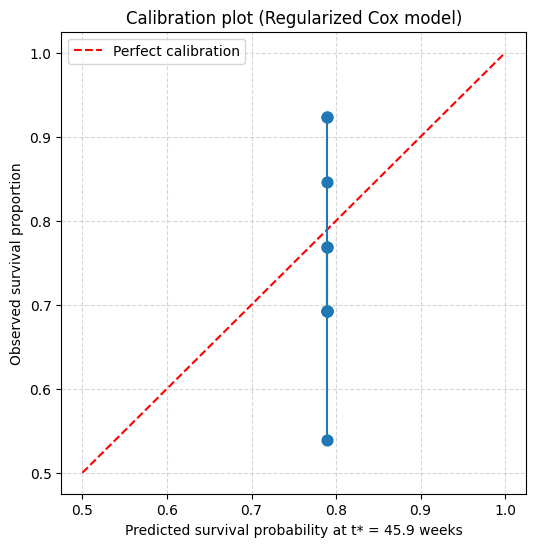

In [ ]:
# Step 3 — Calibration plot for regularized Cox model
# ------------------------------------------------
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Horizon temporel à évaluer ===
t_star = rmst
print(f"Calibration evaluated at t* = {t_star:.1f} weeks")

# === 2. Predicted survival probabilities at t_star ===
surv_df = cph.predict_survival_function(test)

pred_surv_t = np.array([
    np.interp(t_star, surv_df.index.values, surv_df[col].values)
    for col in surv_df.columns
])

# === 3. Observed outcomes ===
df_calib = pd.DataFrame({
    "predicted": pred_surv_t,
    "status": test["arrest"],
    "time": test["week"]
})

# === 4. Binning (deciles) ===
n_bins = 10
df_calib["bin"] = pd.qcut(df_calib["predicted"], q=n_bins, duplicates="drop")

# Compute average predicted survival and observed survival per bin
calibration = df_calib.groupby("bin").apply(
    lambda d: pd.Series({
        "mean_pred": d["predicted"].mean(),
        "obs_surv": np.mean(d["time"] > t_star)
    })
).reset_index(drop=True)

# === 5. Calibration plot ===
plt.figure(figsize=(6, 6))
plt.plot([0.5, 1], [0.5, 1], "k--", label="Perfect calibration", color="red")
plt.scatter(calibration["mean_pred"], calibration["obs_surv"], color="C0", s=60)
plt.plot(calibration["mean_pred"], calibration["obs_surv"], color="C0")
plt.xlabel(f"Predicted survival probability at t* = {t_star:.1f} weeks")
plt.ylabel("Observed survival proportion")
plt.title("Calibration plot (Regularized Cox model)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


Résultat inattendu pour nous : apparemment, pour obtenir de meilleures performances, le modèle de Cox régularisé a choisi de donner toutes les prédictions sous une même valeur.

In [ ]:
pred_surv_t

array([0.78936406, 0.78936436, 0.78936418, 0.78936416, 0.78936415,
       0.78936419, 0.7893641 , 0.78936422, 0.78936424, 0.78936408,
       0.78936415, 0.78936419, 0.78936408, 0.78936416, 0.78936417,
       0.789364  , 0.78936421, 0.78936424, 0.78936414, 0.78936412,
       0.78936411, 0.78936418, 0.7893643 , 0.78936418, 0.78936423,
       0.78936408, 0.7893643 , 0.78936431, 0.78936418, 0.78936433,
       0.78936425, 0.78936421, 0.78936432, 0.78936418, 0.78936427,
       0.78936426, 0.78936417, 0.78936394, 0.78936415, 0.7893641 ,
       0.78936424, 0.78936416, 0.78936409, 0.78936414, 0.78936421,
       0.78936414, 0.78936409, 0.7893642 , 0.789364  , 0.78936431,
       0.78936421, 0.78936417, 0.78936414, 0.78936412, 0.78936419,
       0.78936423, 0.78936419, 0.78936431, 0.78936419, 0.78936418,
       0.78936424, 0.78936408, 0.78936405, 0.7893643 , 0.7893642 ,
       0.7893642 , 0.78936418, 0.78936424, 0.78936412, 0.78936391,
       0.78936415, 0.78936418, 0.7893641 , 0.78936407, 0.78936

In [ ]:
CE = calibration_error(calibration)
print(f"Calibration Error (distance to y=x): {CE:.4f}")

Calibration Error (distance to y=x): 0.1185


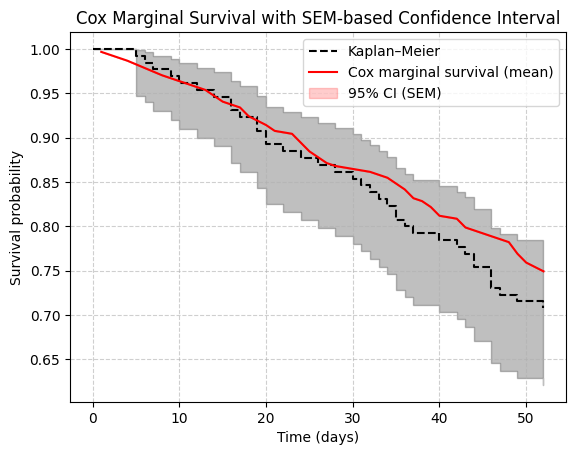

In [ ]:
# Compute mean survival and SEM-based confidence intervals
mean_surv = surv_df.mean(axis=1)
sem = surv_df.std(axis=1) / np.sqrt(surv_df.shape[1])  # SEM across individuals

z = 1.96  # for 95% CI
lower_ci = mean_surv - z * sem
upper_ci = mean_surv + z * sem

# Plot Kaplan–Meier
kmf.fit(test["week"], event_observed=test["arrest"], label="Kaplan–Meier")
ax = kmf.plot(ci_show=True, color="black", linestyle="--")

# Plot Cox mean survival and SEM-based CI
plt.plot(mean_surv.index, mean_surv.values, color="red", label="Cox marginal survival (mean)")
plt.fill_between(mean_surv.index, lower_ci.values, upper_ci.values,
                 color="red", alpha=0.2, label="95% CI (SEM)")

plt.title("Cox Marginal Survival with SEM-based Confidence Interval")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [ ]:
# === Significance threshold ===
alpha_value = 0.05

# === 1. Kolmogorov–Smirnov test ===
# We compare the two empirical survival distributions (Kaplan–Meier vs Cox)
ks_stat, ks_pvalue = ks_2samp(
    kmf.survival_function_.values.flatten(),
    mean_surv.values
)

print("Kolmogorov–Smirnov Test")
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
if ks_pvalue < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: the two survival distributions differ significantly.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference detected.")
print("-" * 70)

# === 2. Log-rank test ===
# For the log-rank test, we need to compare event times between two groups.
# Here we split individuals into "high" vs "low" predicted risk based on the median Cox risk score.
median_risk = cph.predict_partial_hazard(test).median()
group_high = test[cph.predict_partial_hazard(test) > median_risk]
group_low = test[cph.predict_partial_hazard(test) <= median_risk]

results_logrank = logrank_test(
    group_high["week"], group_low["week"],
    event_observed_A=group_high["arrest"],
    event_observed_B=group_low["arrest"]
)

print("Log-rank Test (High vs Low Cox risk)")
print(f"Test statistic: {results_logrank.test_statistic:.4f}, p-value: {results_logrank.p_value:.4f}")
if results_logrank.p_value < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: survival curves are significantly different.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference.")
print("-" * 70)

Kolmogorov–Smirnov Test
KS statistic: 0.1643, p-value: 0.6520
→ Fail to reject H0 at α=0.05: no significant difference detected.
----------------------------------------------------------------------
Log-rank Test (High vs Low Cox risk)
Test statistic: 2.4832, p-value: 0.1151
→ Fail to reject H0 at α=0.05: no significant difference.
----------------------------------------------------------------------


# Discussion et conclusion

### Analyse et Interprétation des résultats

Les tests de concordance (C-index) permettent d'évaluer la capacité d'un modèle de survie à correctement classer les individus selon leur risque : une valeur de 0.5 correspond à une performance aléatoire, tandis qu'une valeur de 1 indique une prédiction parfaite.

Pour nos modèles, nous obtenons les résultats suivants :

- **Modèle de Cox standard** : 0.571  
- **Random Survival Forest (RSF)** : 0.617  
- **Cox régularisé** : 0.628  

Ces résultats montrent que le **Cox régularisé** fournit la meilleure performance en termes de concordance, suivi du **RSF**, puis du **Cox standard**.  
On pourrait donc conclure que la régularisation améliore légèrement la capacité de prédiction du modèle de Cox, et que le modèle RSF, en tant que méthode non paramétrique, capture mieux certaines relations complexes dans les données.

---

Cependant, lorsque nous regardons le **MSE des calibration plots** pour les modèles, une autre interprétation émerge. Notons les erreurs de calibration :  

- **Cox standard** : 0.0947  
- **RSF** : 0.0826  
- **Cox régularisé** : 0.1185  ❗

Cela souligne l'importance d'utiliser plusieurs métriques pour l'évaluation des modèles. Si nous nous arrêtions uniquement au C-index, nous passerions à côté du fait que, pour optimiser artificiellement ses performances, le **Cox régularisé** renvoie les prédictions à une même probabilité de survie. Bien que cela puisse améliorer virtuellement certaines métriques, dans un scénario réel, ce résultat est peu informatif et peu utile.

Nous voyons qu'en réalité, le modèle le plus **stable et adapté** à ce scénario est le **RSF**, qui combine un C-index correct avec le **MSE le plus faible sur le calibration plot**.

Certes, des améliorations restent possibles, car un C-index de 0.61 n'est pas totalement satisfaisant. Mais grâce à cette pipeline d'analyse et à cette méthodologie, nous avons plus de garanties pour obtenir un modèle fiable et robuste.


### Conclusion générale

Reprenons l'objectif du projet qui est d’identifier les caractéristiques qui influencent sur une éventuelle récidive de ces personnes. Pour cela, on a appliquer plusieurs methodes d'analyse de survir, comme le Kaplan-Meier, Random Forest et le modele de Cox standard et regularized.

Grace aux resultats de ces differents modeles, on a pu constater que ertains facteurs influençant la récidive chez des anciens détenus, notamment l'aide financière (variable Fin) et l'expérience professionnelle (variable Wexp), qui semblent réduire le risque de récidive. L'analyse a également montré que le nombre d'antécédents criminels (variable prio) augmente ce risque.

Mais, on note que les resultats obtenus ne sont pas extremement satisfaisant et que quelques limites doivent etre considerees:

*   La taille de l'échantillon (432 individus) est relativement faible
*   Le modèle de Cox suppose une proportionnalité des risques qui n'a pas été entièrement vérifiée
*   Certains facteurs potentiellement importants n'étaient pas disponibles dans le jeu de données (par exemple la categorie socio-professionnel, le sexe ou d'autres caracteristiques personnelles)
*   Les données datent des années 1970 et pourraient ne pas être représentatives des réalités actuelles


Meme avec ces limitations, cette analyse démontre l'utilité des méthodes de survie en criminologie et montre que des interventions comme l'aide financière pourraient avoir un impact positif sur la réinsertion. Il serait interessant de valider les resultats en utilisant un echantillion plus recement et plus robuste.